In [1]:
import sys
from pathlib import Path

# Add project root to Python path so `src` imports work in the notebook
PROJECT_ROOT = Path.cwd().resolve().parent  # notebook lives in notebooks/
if str(PROJECT_ROOT) not in sys.path:
    sys.path.insert(0, str(PROJECT_ROOT))

# Optional: ensure ASI library path is set for camera init
ASI_LIB_PATH = PROJECT_ROOT / "third-party" / "asi-sdk" / "libASICamera2.so.1.37"

print(f"PYTHONPATH updated with {PROJECT_ROOT}")
print(f"ASI_LIB_PATH set to {ASI_LIB_PATH}")


PYTHONPATH updated with /workspaces/fringe-displacement-analysis
ASI_LIB_PATH set to /workspaces/fringe-displacement-analysis/third-party/asi-sdk/libASICamera2.so.1.37


## Overview

This notebook is organized in two main parts:

1. **Data acquisition and calibration** — The first half of the notebook configures and controls an ASI camera and a LabJack device to inject a synthetic waveform, capture a sequence of raw frames, crop the frames, and calibrate the relationship between the injected voltage and the photodiode response. A large code block orchestrates multithreaded acquisition, saving, cropping, and calibration steps.

2. **Fringe displacement analysis** — The second half reads the cropped fringe images and calculates the displacement of the interference fringes using FFT‑based phase tracking. It defines helper functions, performs the computation, and visualizes the results.

The following sections provide detailed descriptions and code for each step.

### Import required libraries

This cell imports essential Python modules, including standard libraries (such as `os`, `time`, `threading`, `queue`, and `shutil`) and scientific libraries (`numpy`, `matplotlib.pyplot`, and `scipy.optimize`). It also imports custom modules (`LAPPTP_stream_lib` for injection/detection and `GW_generator_2024` for generating gravitational-wave-like signals). At the end, it prints confirmation that the import completed successfully.

In [2]:
from __future__ import annotations
import os, time, threading, queue, shutil
from datetime import datetime
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from src.LAPPTP_stream_lib import inject_detect
from src import GW_generator_2024 as GW
import math
import csv
from pathlib import Path
from typing import List, Tuple, Dict, Any
import cv2

print('Import done')

Import done


### Camera configuration and capture settings

This cell defines the camera configuration and capture parameters, such as frame size, binning factor, exposure, gain, and gamma settings. It also specifies paths for saving captures, cropping parameters for later processing, and options for saving frames in memory or as JPEGs. The region-of-interest (ROI) and cropping coordinates defined here are used later when cropping saved frames.

In [3]:
#Camera's Parameters 
USE_CAMERA = True
ASI_LIB_PATH = os.environ.get(
    "ASI_LIB_PATH",
    "third-party/asi-sdk/libASICamera2.so"
)
ROI_W = ROI_H = 176         
BIN = 2                     
IMAGE_TYPE_RAW8 = True       # grayscale
EXP_US = 1000                             
GAIN   = 130
GAMMA  = 60
BANDWIDTH = 80               
WARMUP_FRAMES = 6
CAPTURE_TIMEOUT_MS = 7

# saving strategy
SAVE_DURING_INJECTION = False
SAVE_AS_JPEG = False
JPEG_QUALITY = 80
FRAME_QUEUE_MAX = 512

RUN_TAG   = datetime.now().strftime("%Y%m%d_%H%M%S")
FINAL_DIR = "data/Capture"
RAM_DIR = FINAL_DIR

os.makedirs(RAM_DIR, exist_ok=True)
os.makedirs(FINAL_DIR, exist_ok=True)

# =========================
# Fixed crop parameters (after capture)
# =========================
# ROI for cropping saved frames (top-left x,y and width,height)
CROP_X, CROP_Y, CROP_W, CROP_H = 0, 40, 220, 90
CROP_INPUT_DIR = FINAL_DIR   # where frames are saved
CROP_OUTPUT_DIR = "data/crop"     # where cropped frames will be written

# stack all frames then save one .npz (fastest)
STACK_IN_MEMORY = False
EST_FRAMES = 2500

# Image extensions we will accept
IMG_EXTS = {".png", ".jpg", ".jpeg", ".bmp", ".tif", ".tiff"}

print(' Done')

 Done


### Gravitational‑wave signal generation and calibration functions

This cell sets up tunable parameters for generating a synthetic gravitational-wave (GW) signal. It defines the voltage range (`vmin`, `vmax`), the scan rate, and the duration. It also defines helper functions `sinuscal` and `arcsincal` to model the relationship between the injected DAC voltage and the photodiode response, and its inverse. These functions will later be used to fit and reconstruct the DAC waveform from measured photodiode data.

In [4]:
# GW signal + calibration tunables
vmin, vmax = 2, 4     
scanrate_hz = 1000
duration_s = 5         

def sinuscal(x, A, omega, phase, B):  # photodiode = f(dac)
    return A * np.sin(omega * x + phase) + B

def arcsincal(y, A, omega, phase, B): # inverse: dac = f^{-1}(photodiode)
    arg = (y - B) / A
    arg = np.clip(arg, -1.0, 1.0)
    return (np.arcsin(arg) - phase) / omega

print(' Done')

 Done


### Acquire fringe images and photodiode measurements

This large cell orchestrates the data acquisition and preliminary processing:

- It sets up shared events, queues, and a statistics dictionary for multi‑threaded image capture.
- It defines helper functions for stacking frames in memory and writing individual frames to disk.
- It implements a `camera_worker` function that initializes and configures the ASI camera, captures frames continuously, and enqueues them for saving while recording capture statistics.
- The cell starts the writer and camera threads (if `USE_CAMERA` is enabled), builds a synthetic gravitational‑wave waveform, triggers injection via `inject_detect`, and records the photodiode output.
- After the injection completes, it stops the camera, waits for threads to finish, optionally stacks frames or moves saved frames from a RAM directory to a final directory, and crops the captured frames based on the predefined ROI.
- It then fits the photodiode response to the injected voltage using a sinusoidal model, reconstructs the DAC input from the photodiode output, plots the injected and measured signals, and prints capture statistics. Finally, it saves the injected waveform to `template.txt`.

Because this cell performs many operations, reading through the comments and print statements can help you follow the sequence of steps.

In [5]:
# Shared capture state 
go_event = threading.Event()
stop_event = threading.Event()
io_done_event = threading.Event()
frame_q: "queue.Queue[tuple[str, np.ndarray]]" = queue.Queue(maxsize=FRAME_QUEUE_MAX)
stats = dict(
    t0=None, t1=None,
    frames_captured=0, frames_enqueued=0, frames_saved=0,
    frames_dropped=0, capture_errors=0, io_errors=0
)

stack_buf = None
stack_len = 0
stack_lock = threading.Lock()

def _ensure_stack(h, w):
    global stack_buf
    if stack_buf is None:
        stack_buf = np.empty((EST_FRAMES, h, w), dtype=np.uint8)

def _append_to_stack(gray):
    global stack_buf, stack_len
    with stack_lock:
        if stack_buf is None or stack_len >= stack_buf.shape[0]:
            new_n = int((stack_buf.shape[0] if stack_buf is not None else EST_FRAMES) * 1.5)
            new_buf = np.empty((new_n, gray.shape[0], gray.shape[1]), dtype=np.uint8)
            if stack_buf is not None and stack_len > 0:
                new_buf[:stack_len] = stack_buf[:stack_len]
            stack_buf = new_buf
        stack_buf[stack_len] = gray
        stack_len += 1

def writer_worker():
    import cv2
    while not (stop_event.is_set() and frame_q.empty()):
        try:
            out_path, gray = frame_q.get(timeout=0.05)
        except queue.Empty:
            continue
        try:
            ok = False
            if SAVE_AS_JPEG:
                ok, enc = cv2.imencode(".jpg", gray, [int(cv2.IMWRITE_JPEG_QUALITY), JPEG_QUALITY])
                if ok:
                    with open(out_path[:-3] + "jpg", "wb") as f:
                        f.write(bytearray(enc))
            else:
                ok = cv2.imwrite(out_path, gray)
            if ok:
                stats["frames_saved"] += 1
            else:
                stats["io_errors"] += 1
        except Exception:
            stats["io_errors"] += 1
        finally:
            frame_q.task_done()
    io_done_event.set()

def set_bin_aware_roi(cam, props, req_w_unbinned, req_h_unbinned, bin_fac, img_type):
    """ROI sizes & start are in *binned* pixels; keep everything safely aligned."""
    maxW_unb = int(props["MaxWidth"]); maxH_unb = int(props["MaxHeight"])
    out_w = req_w_unbinned // bin_fac
    out_h = req_h_unbinned // bin_fac
    maxW_bin = maxW_unb // bin_fac; maxH_bin = maxH_unb // bin_fac
    snap_even = lambda v: v & ~1
    out_w = max(8, snap_even(out_w)); out_h = max(8, snap_even(out_h))
    start_x_bin = snap_even(max(0, (maxW_bin - out_w) // 2))
    start_y_bin = snap_even(max(0, (maxH_bin - out_h) // 2))
    if start_x_bin + out_w > maxW_bin: start_x_bin = snap_even(maxW_bin - out_w)
    if start_y_bin + out_h > maxH_bin: start_y_bin = snap_even(maxH_bin - out_h)
    start_x_bin = max(0, start_x_bin); start_y_bin = max(0, start_y_bin)
    cam.set_roi_format(out_w, out_h, bin_fac, img_type)
    if hasattr(cam, "set_roi"):
        cam.set_roi(start_x_bin, start_y_bin, out_w, out_h)
    elif hasattr(cam, "set_start_position"):
        cam.set_start_position(start_x_bin, start_y_bin)
    print(f" ROI set: requested(unbinned)={req_w_unbinned}x{req_h_unbinned}, BIN={bin_fac} "
          f"→ output={out_w}x{out_h}, start(binned)={start_x_bin},{start_y_bin}, "
          f"sensor(binned)={maxW_bin}x{maxH_bin}")

def camera_worker():
    try:
        import zwoasi as asi
        import cv2
        try:
            asi.init(ASI_LIB_PATH)
        except RuntimeError as e:
            print(" ASI init:", e)
        cams = asi.list_cameras()
        if not cams:
            print(" No camera detected."); return
        cam = asi.Camera(0)
        props = cam.get_camera_property()
        print(f" {props.get('Name','?')}  ({props.get('MaxWidth')}x{props.get('MaxHeight')})")
        cam.disable_dark_subtract()
        cam.set_control_value(asi.ASI_EXPOSURE, EXP_US, auto=False)
        cam.set_control_value(asi.ASI_GAIN,     GAIN,   auto=False)
        cam.set_control_value(asi.ASI_GAMMA,    GAMMA,  auto=False)
        try: cam.set_control_value(asi.ASI_BANDWIDTHOVERLOAD, BANDWIDTH, auto=False)
        except Exception: pass
        for key in ("ASI_HIGH_SPEED_MODE", "ASI_USBTRAFFIC"):
            if hasattr(asi, key):
                try: cam.set_control_value(getattr(asi, key), 1, auto=False)
                except Exception: pass
        print(" Controls set")

        img_type = getattr(asi, "ASI_IMG_RAW8", 0) if IMAGE_TYPE_RAW8 else getattr(asi, "ASI_IMG_RAW16", 1)
        set_bin_aware_roi(cam, props, ROI_W, ROI_H, BIN, img_type)
        cam.start_video_capture()
        for _ in range(WARMUP_FRAMES):
            try: cam.capture_video_frame(timeout=0)
            except Exception: pass

        print("🕒 Armed; waiting for go_event()")
        while not stop_event.is_set() and not go_event.is_set():
            time.sleep(0.001)
        if stop_event.is_set():
            return

        stats["t0"] = time.perf_counter()
        last_print = stats["t0"]; frame_count_last = 0
        print(" START capture window (RAW8 BIN=2)")

        idx = 0
        while not stop_event.is_set():
            try:
                gray = cam.capture_video_frame(timeout=CAPTURE_TIMEOUT_MS)
                if gray is None: continue
                if gray.ndim != 2:
                    gray = cv2.cvtColor(gray, cv2.COLOR_BGR2GRAY)
            except Exception as e:
                if "TIMEOUT" in str(e).upper(): continue
                stats["capture_errors"] += 1
                if stats["capture_errors"] <= 5 or stats["capture_errors"] % 100 == 0:
                    print(f" capture_video_frame() exception [{stats['capture_errors']}]: {e}")
                time.sleep(0.001); continue

            stats["frames_captured"] += 1

            if STACK_IN_MEMORY:
                if stack_buf is None: _ensure_stack(gray.shape[0], gray.shape[1])
                _append_to_stack(gray)
            else:
                ts = datetime.now().strftime("%Y%m%d_%H%M%S_%f")
                base = os.path.join(RAM_DIR, f"frame_{ts}_{idx:06d}.png")
                try:
                    frame_q.put_nowait((base, gray))
                    stats["frames_enqueued"] += 1
                except queue.Full:
                    stats["frames_dropped"] += 1

            now = time.perf_counter()
            if now - last_print >= 1.0:
                delta_f = stats["frames_captured"] - frame_count_last
                fps_live = delta_f / (now - last_print)
                print(f" Live FPS: {fps_live:6.2f}  |  Total frames: {stats['frames_captured']}")
                last_print, frame_count_last = now, stats["frames_captured"]

            idx += 1

        stats["t1"] = time.perf_counter()
        print(" STOP capture window")

    finally:
        try: cam.stop_video_capture()
        except Exception: pass
        try: cam.close()
        except Exception: pass
        print("  Camera closed")

# Start camera (armed) 
writer_th = None
if USE_CAMERA:
    if not STACK_IN_MEMORY and not SAVE_DURING_INJECTION:
        writer_th = threading.Thread(target=writer_worker, daemon=True)
        writer_th.start()
    cam_th = threading.Thread(target=camera_worker, daemon=True)
    cam_th.start()
    print(" Camera armed (BIN=2) and waiting for injection start")

# Build GW waveform (DAC0) 
gw_signal = GW.generation(30, 30, 1, 0, 0, 0, 0, None, scanrate_hz)
gw_signal = np.array(gw_signal)
gw_signal_norm = (gw_signal - gw_signal.min()) / (gw_signal.max() - gw_signal.min())
waveform_voltage = vmin + gw_signal_norm * (vmax - vmin)

# Inject + measure (gated capture!) 
print(" LabJack: preparing to start injection")
go_event.set()  # <--- camera starts saving right now
print(" Injection START → camera capturing (BIN=2)")
photodiode_output = inject_detect(waveform_voltage.tolist(), scanrate_hz)
print(" Injection STOP")

# Stop camera & flush 
if USE_CAMERA:
    stop_event.set()
    cam_th.join(timeout=5)
    if not STACK_IN_MEMORY and not SAVE_DURING_INJECTION:
        frame_q.join()
        io_done_event.wait(timeout=30)
    if STACK_IN_MEMORY and stack_len > 0:
        with stack_lock:
            stack_final = stack_buf[:stack_len].copy()
        npz_path = os.path.join(RAM_DIR, f"stack_{RUN_TAG}.npz")
        np.savez_compressed(npz_path, frames=stack_final)
        print(f" Saved stack: {stack_final.shape} → {npz_path}")
        if SAVE_AS_JPEG:
            import cv2
            export_dir = os.path.join(RAM_DIR, "export_jpg")
            os.makedirs(export_dir, exist_ok=True)
            for i in range(stack_final.shape[0]):
                cv2.imwrite(os.path.join(export_dir, f"f_{i:06d}.jpg"),
                           stack_final[i], [int(cv2.IMWRITE_JPEG_QUALITY), JPEG_QUALITY])
            print(f" Exported {stack_final.shape[0]} JPEGs to {export_dir}")

# Move data only if RAM_DIR differs from FINAL_DIR
if RAM_DIR != FINAL_DIR:
    dest = os.path.join(FINAL_DIR, f"run_{RUN_TAG}")
    shutil.move(RAM_DIR, dest)
    print(f" Moved run data from RAM → {dest}")

# =========================
# Fixed batch crop (no detection, no rotation)
# Crops frames saved in Capture -> writes cropped frames to ./crop
# =========================
from pathlib import Path
import cv2

ALLOWED_EXTS = {".jpg", ".jpeg", ".png", ".bmp", ".tif", ".tiff", ".webp"}
def _is_image_file(p: Path) -> bool:
    return p.is_file() and p.suffix.lower() in ALLOWED_EXTS

def _clamp_roi(x: int, y: int, w: int, h: int, img_w: int, img_h: int):
    cx = max(0, x); cy = max(0, y)
    x2 = min(x + w, img_w); y2 = min(y + h, img_h)
    cw = x2 - cx; ch = y2 - cy
    if cw <= 0 or ch <= 0:
        return None
    return cx, cy, cw, ch

# If frames were moved into a run_* subfolder, crop from there
_crop_in = Path(CROP_INPUT_DIR)
if RAM_DIR != FINAL_DIR:
    _candidate = Path(FINAL_DIR) / f"run_{RUN_TAG}"
    if _candidate.exists() and _candidate.is_dir():
        _crop_in = _candidate

_crop_out = Path(CROP_OUTPUT_DIR)
_crop_out.mkdir(parents=True, exist_ok=True)

_files = sorted([p for p in _crop_in.iterdir() if _is_image_file(p)])
if not _files:
    print(f"[CROP] No images found in: {_crop_in}")
else:
    ok, fail = 0, 0
    for in_path in _files:
        img = cv2.imread(str(in_path), cv2.IMREAD_UNCHANGED)
        if img is None:
            print(f"[CROP][FAIL] Read: {in_path.name}")
            fail += 1
            continue

        ih, iw = img.shape[:2]
        roi = _clamp_roi(int(CROP_X), int(CROP_Y), int(CROP_W), int(CROP_H), iw, ih)
        if roi is None:
            print(f"[CROP][FAIL] ROI out of bounds: {in_path.name} (img {iw}x{ih})")
            fail += 1
            continue

        cx, cy, cw, ch = roi
        cropped = img[cy:cy + ch, cx:cx + cw].copy()

        out_path = _crop_out / in_path.name
        if not cv2.imwrite(str(out_path), cropped):
            print(f"[CROP][FAIL] Write: {out_path.name}")
            fail += 1
            continue

        ok += 1

    print(f"[CROP] Done. Cropped: {ok} | Failed: {fail}  (ROI={CROP_X},{CROP_Y},{CROP_W},{CROP_H})")


 Camera armed (BIN=2) and waiting for injection start
 LabJack: preparing to start injection
 Injection START → camera capturing (BIN=2)
Beginning...
Opened a LabJack with Device type: 4, Connection type: 1,
Serial number: 440010450, IP address: 0.0.0.0, Port: 0,
Max bytes per MB: 64

Initializing stream out buffers...
Number of signal slices : 39
128
  Wrote STREAM_OUT0 state: slice0
old index : 0
new index : 1

STREAM_OUT0_BUFFER_STATUS = 128.000000
Updating STREAM_OUT0 buffer whenever STREAM_OUT0_BUFFER_STATUS is greater or equal to 128
scans per read = 128
['STREAM_OUT0_BUFFER_STATUS']
scan_list: [0, 4800]
scans_per_read: 128
out_context state size 128

Stream started with a scan rate of 1000 Hz.

Performing 39 buffer updates.
  Wrote STREAM_OUT0 state: slice1
old index : 1
new index : 2

eStreamRead 0
  1st scan out of 256: AIN0 = 2.53546
  Wrote STREAM_OUT0 state: slice2
old index : 2
new index : 3
 ZWO ASI662MC  (1920x1080)

eStreamRead 1
  1st scan out of 256: AIN0 = 2.55616
  

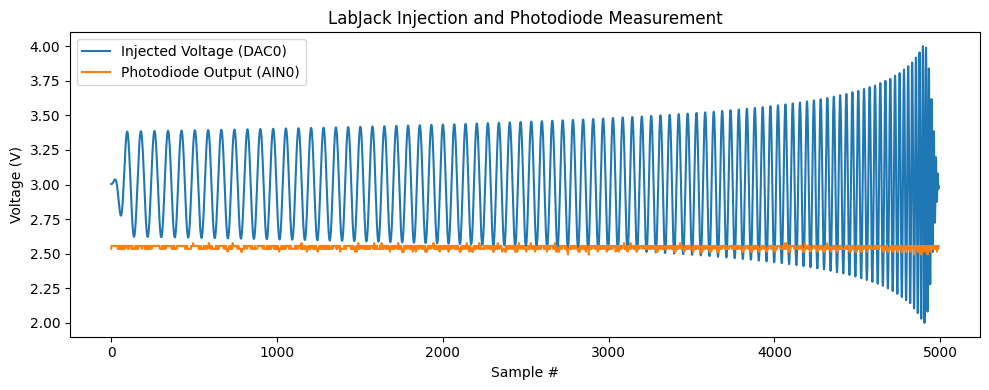

 Captured=1645 | Enqueued=1645 | Saved=1645 | Dropped=0 | Capture errors=0 | IO errors=0
 Duration=4.632s → Average FPS ≈ 355.14


In [6]:
# Calibration fit & plots 
# fix any sample mismatch
minlen = min(len(waveform_voltage), len(photodiode_output))
wv = waveform_voltage[:minlen]
pd = photodiode_output[:minlen]

# Fit photodiode = A*sin(omega*DAC + phase) + B (fallback to linear if fit fails)
try:
    params, _ = curve_fit(sinuscal, wv, pd, p0=[1, 1, 0, 0], maxfev=5000)
    A, omega, phase, B = params
    input_reconstructed = arcsincal(pd, A, omega, phase, B)
except Exception as e:
    print(f"[CAL] Sinus fit failed ({type(e).__name__}: {e}); falling back to linear map")
    slope, intercept = np.polyfit(pd, wv, 1)
    A, omega, phase, B = 0, 0, 0, intercept
    input_reconstructed = slope * pd + intercept

# Plot DAC & photodiode traces
plt.figure(figsize=(10,4))
plt.plot(wv, label='Injected Voltage (DAC0)')
plt.plot(pd, label='Photodiode Output (AIN0)')
plt.xlabel('Sample #')
plt.ylabel('Voltage (V)')
plt.legend()
plt.title('LabJack Injection and Photodiode Measurement')
plt.tight_layout()
plt.show()

# Final capture stats
if USE_CAMERA:
    t0 = stats["t0"] or time.perf_counter()
    t1 = stats["t1"] or time.perf_counter()
    dt = max(1e-6, t1 - t0)
    fps = stats["frames_captured"] / dt if stats["frames_captured"] else 0.0
    print(
        f" Captured={stats['frames_captured']} | "
        f"Enqueued={stats['frames_enqueued']} | "
        f"Saved={stats['frames_saved']} | "
        f"Dropped={stats['frames_dropped']} | "
        f"Capture errors={stats['capture_errors']} | IO errors={stats['io_errors']}"
    )
    print(f" Duration={dt:.3f}s → Average FPS ≈ {fps:.2f}")
np.savetxt("template.txt", waveform_voltage)  # one value per line


### Fringe displacement (FFT phase tracking)

This section processes the cropped fringe frames (default directory: `crop/`) and computes the displacement of the interference pattern as a function of frame index. The results are saved in the output directory `disp/` for further analysis and plotting.

### Helper function: list images in a directory

This helper function, `list_images_sorted`, returns a sorted list of image files contained in a specified directory. It iterates through the directory, filters files by extension, and sorts them alphabetically. This utility is used to load cropped fringe frames in order.

In [7]:
# ---- Helper: list images in a directory (sorted) ----
def list_images_sorted(in_dir: Path) -> List[Path]:
    files: List[Path] = []
    for p in in_dir.iterdir():
        if p.is_file() and p.suffix.lower() in IMG_EXTS:
            files.append(p)
    files.sort()
    return files


### Helper function: draw a 1D curve

This helper function, `draw_1d_curve`, creates a simple line plot as an image. Given a sequence of numeric values, it draws a red polyline on a white background with labeled axes. It returns the resulting image array using OpenCV. The function is useful for visualizing displacement values as an image file.

In [8]:
# ---- Helper: draw a 1D curve to an OpenCV image (for saving as PNG) ----
def draw_1d_curve(values: List[float], height: int = 400, width: int = 800) -> np.ndarray:
    """White background + axes + red polyline (OpenCV BGR)."""
    graph = np.full((height, width, 3), 255, dtype=np.uint8)

    if len(values) < 2:
        return graph

    min_val = float(min(values))
    max_val = float(max(values))
    if abs(max_val - min_val) < 1e-12:
        max_val = min_val + 1e-12

    margin = 40
    # axes (black)
    cv2.line(graph, (margin, margin), (margin, height - margin), (0, 0, 0), 1)
    cv2.line(graph, (margin, height - margin), (width - margin, height - margin), (0, 0, 0), 1)

    n = len(values)
    pts: List[Tuple[int, int]] = []
    for i, v in enumerate(values):
        norm = (float(v) - min_val) / (max_val - min_val)  # 0..1
        x = i * (width - 2 * margin - 1) / (n - 1) + margin
        y = (1.0 - norm) * (height - 2 * margin - 1) + margin
        pts.append((int(round(x)), int(round(y))))

    for i in range(1, len(pts)):
        cv2.line(graph, pts[i - 1], pts[i], (0, 0, 255), 2)  # red

    return graph


### Core computation: compute fringe displacement

This cell defines the core function `compute_fringe_displacement`, which processes a sequence of cropped fringe images to compute the displacement of the interference pattern in pixels. The function uses Fast Fourier Transform (FFT) to identify the dominant frequency bin and track phase shifts between frames. It returns a dictionary of results including the dominant frequency index, spatial frequency (`fx`), displacement values, and paths to output CSV and PNG files. Optional arguments control whether to save results to disk and display them.

In [9]:
# ---- Core computation ----
def compute_fringe_displacement(
    in_dir: str | Path = "data/crop",
    out_dir: str | Path = "data/disp",
    save: bool = True,
    show: bool = True,
) -> Dict[str, Any]:
    """Compute displacement (pixels) from a sequence of fringe images.

    Steps:
      1) Horizontal footprint: average over rows
      2) FFT of footprint
      3) Track phase at dominant spatial frequency
      4) Phase unwrap
      5) Convert phase change -> displacement in pixels

    Returns a dict with keys:
      files, fx, dom_index, phases, phases_unwrap, disp_pixels, csv_path, png_path
    """
    in_dir = Path(in_dir)
    out_dir = Path(out_dir)

    if not in_dir.exists() or not in_dir.is_dir():
        raise FileNotFoundError(f"Input directory does not exist or is not a directory: {in_dir}")

    files = list_images_sorted(in_dir)
    if len(files) < 2:
        raise ValueError(f"Need at least 2 frames in {in_dir} (found {len(files)}).")

    phases: List[float] = []
    dom_index = -1
    fx = 0.0
    width = 0

    # ---- Analyze each frame ----
    for idx, p in enumerate(files):
        img = cv2.imread(str(p), cv2.IMREAD_GRAYSCALE)
        if img is None or img.size == 0:
            # skip unreadable frames
            continue

        img_f = img.astype(np.float32)
        img_f -= float(np.mean(img_f))

        width = int(img_f.shape[1])

        # horizontal footprint (avg over rows)
        profile = np.mean(img_f, axis=0, dtype=np.float32)  # (width,)
        profile = profile.reshape(1, -1)  # (1,width)

        # FFT (complex output)
        complex_row = cv2.dft(profile, flags=cv2.DFT_COMPLEX_OUTPUT)  # (1,width,2)
        re = complex_row[0, :, 0]
        im = complex_row[0, :, 1]

        if idx == 0:
            mag = cv2.magnitude(re, im).astype(np.float32)
            mag[0] = 0.0  # ignore DC
            dom_index = int(np.argmax(mag))
            fx = float(dom_index) / float(width)

            if fx == 0.0:
                raise RuntimeError("Dominant frequency fx is 0. Cannot compute displacement.")

        phase = math.atan2(float(im[dom_index]), float(re[dom_index]))
        phases.append(phase)

    if len(phases) < 2:
        raise RuntimeError("Not enough readable frames after loading.")

    # ---- Phase unwrap (same logic as the C++ version) ----
    phases_unwrap = [0.0] * len(phases)
    phases_unwrap[0] = phases[0]
    for i in range(1, len(phases)):
        dp = phases[i] - phases[i - 1]
        while dp > math.pi:
            dp -= 2.0 * math.pi
        while dp < -math.pi:
            dp += 2.0 * math.pi
        phases_unwrap[i] = phases_unwrap[i - 1] + dp

    # ---- Convert phase -> displacement (pixels) ----
    disp_pixels = [(pu - phases_unwrap[0]) / (2.0 * math.pi * fx) for pu in phases_unwrap]

    csv_path = None
    png_path = None

    if save:
        out_dir.mkdir(parents=True, exist_ok=True)

        # CSV
        csv_path = out_dir / "fringe_displacement.csv"
        with csv_path.open("w", newline="") as f:
            w = csv.writer(f)
            w.writerow(["frame", "phase_unwrapped", "displacement_pixels"])
            for i, (ph_u, dpx) in enumerate(zip(phases_unwrap, disp_pixels)):
                w.writerow([i, ph_u, dpx])

        # PNG graph (OpenCV)
        graph = draw_1d_curve(disp_pixels, height=400, width=800)
        png_path = out_dir / "fringe_displacement.png"
        ok = cv2.imwrite(str(png_path), graph)
        if not ok:
            png_path = None

    # ---- Notebook plot ----
    if show:
        plt.figure()
        plt.plot(disp_pixels)
        plt.title("Fringe displacement (pixels)")
        plt.xlabel("Frame")
        plt.ylabel("Displacement (px)")
        plt.grid(True)
        plt.show()

    return {
        "files": files,
        "fx": fx,
        "dom_index": dom_index,
        "phases": phases,
        "phases_unwrap": phases_unwrap,
        "disp_pixels": disp_pixels,
        "csv_path": csv_path,
        "png_path": png_path,
    }


### Set parameters and preview the first cropped frame

Here we specify the input directory (`IN_DIR`) containing cropped fringe images and the output directory (`OUT_DIR`) where displacement results will be saved. The cell also performs a quick sanity check: if any images are present, it reads and displays the first frame using Matplotlib. This preview helps ensure that the input data looks reasonable before running the full analysis.

Frames found: 1645


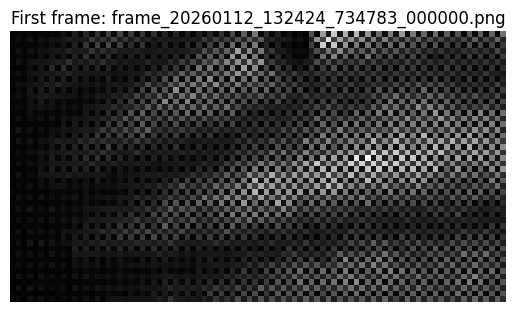

In [10]:
# ---- Parameters (edit these) ----
IN_DIR = Path("data/crop")   # folder containing cropped fringe images
OUT_DIR = Path("data/disp")  # output folder

# Optional: quick sanity check (show first frame)
files_preview = list_images_sorted(IN_DIR) if IN_DIR.exists() else []
print("Frames found:", len(files_preview))
if files_preview:
    img0 = cv2.imread(str(files_preview[0]), cv2.IMREAD_GRAYSCALE)
    plt.figure()
    plt.imshow(img0, cmap="gray")
    plt.title(f"First frame: {files_preview[0].name}")
    plt.axis("off")
    plt.show()


### Run the fringe displacement computation

This final code cell invokes `compute_fringe_displacement` with the specified directories and displays the key results. It prints the dominant FFT bin and the spatial frequency in cycles per pixel, shows the file paths for the exported CSV and PNG files, and reports the first and last displacement values.

Running this cell executes the fringe displacement analysis and produces the output files.

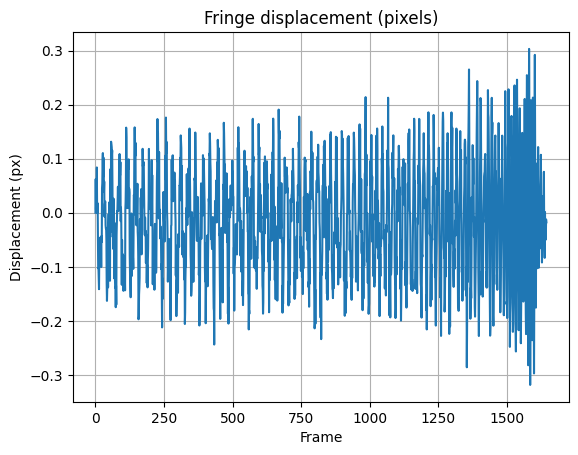

Dominant FFT bin : 1
fx (cycles/pixel): 0.011363636363636364
CSV: data/disp/fringe_displacement.csv
PNG: data/disp/fringe_displacement.png
First/last displacement (px): 0.0 -> -0.01769699458611081


In [11]:
# ---- Run ----
result = compute_fringe_displacement(IN_DIR, OUT_DIR, save=True, show=True)

print("Dominant FFT bin :", result["dom_index"])
print("fx (cycles/pixel):", result["fx"])
print("CSV:", result["csv_path"])
print("PNG:", result["png_path"])
print("First/last displacement (px):", result["disp_pixels"][0], "->", result["disp_pixels"][-1])


### Convert to mirror displacement

This cell converts the fringe displacement (in pixels) to physical mirror displacement. The conversion requires calibration parameters: pixel size, magnification, wavelength, and interferometer geometry. For a typical Michelson interferometer, one fringe period corresponds to λ/2 mirror displacement (since the optical path changes by 2× the mirror motion).

In [ ]:
# ---- Calibration parameters ----
# Adjust these values based on your optical setup
wavelength_nm = 632.8          # HeNe laser wavelength (nm)
pixel_size_um = 3.75           # Camera pixel size (µm) - typical for ASI662MC with BIN=2
magnification = 1.0            # Optical magnification factor
interferometer_factor = 2.0    # Path multiplier: 2 for Michelson (double-pass)

# Calculate conversion factor
# One fringe period in pixels corresponds to λ/(2*magnification) mirror displacement
wavelength_um = wavelength_nm / 1000.0
fringe_period_um = wavelength_um / interferometer_factor  # Mirror displacement per fringe
pixels_per_fringe = 1.0 / result["fx"]  # pixels per fringe period
um_per_pixel = (fringe_period_um / pixels_per_fringe) * magnification

# Convert fringe displacement (pixels) to mirror displacement (µm)
mirror_disp_um = np.array(result["disp_pixels"]) * um_per_pixel

# Also convert to nanometers for convenience
mirror_disp_nm = mirror_disp_um * 1000.0

# Plot mirror displacement
plt.figure(figsize=(10,5))
plt.plot(mirror_disp_nm, linewidth=1)
plt.title("Mirror Displacement (converted from fringe tracking)")
plt.xlabel("Frame")
plt.ylabel("Mirror Displacement (nm)")
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

print(f"Calibration:")
print(f"  Wavelength: {wavelength_nm} nm")
print(f"  Pixel size: {pixel_size_um} µm")
print(f"  Fringe spatial frequency: {result['fx']:.6f} cycles/pixel")
print(f"  Pixels per fringe: {pixels_per_fringe:.2f}")
print(f"  Conversion factor: {um_per_pixel:.6f} µm/pixel = {um_per_pixel*1000:.3f} nm/pixel")
print(f"\nMirror displacement range:")
print(f"  {mirror_disp_nm[0]:.3f} nm → {mirror_disp_nm[-1]:.3f} nm")
print(f"  Total excursion: {np.ptp(mirror_disp_nm):.3f} nm (peak-to-peak)")
print(f"  RMS: {np.std(mirror_disp_nm):.3f} nm")